# Simple TokaMaker static equilibrium example for LTX-$\beta$

In [1]:
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.interpolate import CubicSpline
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Load TokaMaker library

To load the TokaMaker python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or using within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` on macOS).

In [2]:
tokamaker_python_path = '/Users/hansec/Research/OpenFUSIONToolkit/install_release' #os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))
from OpenFUSIONToolkit.TokaMaker import TokaMaker, load_gs_mesh, create_isoflux

## Setup solver

### Initialize TokaMaker object
First we create a TokaMaker instance to use for equilibrium calculations. Note at present only a single instance can be used per python kernel, so this command should only be called **once** in a given Jupyter notebook or python script. In the future this restriction may be relaxed.

In [3]:
mygs = TokaMaker(nthreads=2)

#----------------------------------------------
OpenFUSIONToolkit Initialized
Development branch:   tMaker_nonaxi_wall
Revision id:          3483915
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------



### Load mesh into TokaMaker
Now we load the mesh generated in "LTX_mesh_ex.ipynb" using `load_gs_mesh` and `setup_mesh`. Then we use `setup_regions` to define the different region types. Finally, we call `setup` to setup the required solver objects. During this call we can specify the desired element order (min=2, max=4) and the toroidal field through F0 = B0*R0, where B0 is the toroidal field at a reference location R0.

We also increase the maximum number of Picard iterations in the equilibrium solve to 80 from the default of 40.

In [4]:
mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict = load_gs_mesh('LTX_mesh.h5')
# cond_dict['SHELLL']['noncontinuous'] = True #False
# cond_dict['SHELLU']['noncontinuous'] = True #False
mygs.settings.maxits=80
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict)
mygs.setup(order=2, F0=0.10752)


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  2.640E+00
    # of points  =    3125
    # of edges   =    9232
    # of cells   =    6108
    # of boundary points =     140
    # of boundary edges  =     140
    # of boundary cells  =     140
  Resolution statistics:
    hmin =  2.294E-03
    hrms =  3.356E-02
    hmax =  7.597E-02
  Surface grounded at vertex     497


**** Creating Lagrange FE space
  Order  =    2
  Minlev =   -1

 Computing flux BC matrix 
 Inverting real matrix
   Time =    1.4790000000000001E-003


### Define a vertical stability coil
Like many elongated equilibria, the equilibria we seek to compute below is vertically unstable. So we define a pair of coils, and corresponding polarities, that will be used to control the vertical position in the equilibrium solve. In this case we use the "INTERNAL" coils, but in practice this stability is likely provided largely by the shell when plasma are sufficiently elongated.

In [5]:
vsc_signs = np.zeros((mygs.ncoils,), dtype=np.float64)
vsc_signs[[coil_dict['INTERNALU']['coil_id'], coil_dict['INTERNALL']['coil_id']]] = [1.0,-1.0]
mygs.set_coil_vsc(vsc_signs)

### Define hard limits on coil currents
Hard limits on coil currents can be set using `set_coil_bounds`, which are then used in the shape fitting below.

Note that the size of the bounds array is (ncoils+1,2) as bounds can also be set for the VSC set, which is treated as a separate degree of freedom (virtual coil) if defined.

In [6]:
coil_bounds = np.zeros((mygs.ncoils+1,2), dtype=np.float64)
coil_bounds[:,0] = -1.E98; coil_bounds[:,1] = 1.E98
for name, coil in coil_dict.items():
    if name.startswith('OH'):
        bounds = [-20.E3, 20.E3]
    elif name.startswith('RED'):
        bounds = [-5.E3, 5.E3]
    elif name.startswith('INTERNAL'):
        bounds = [-10.E3, 10.E3]
    elif name.startswith('GREEN'):
        bounds = [-2.E3, 2.E3]
    elif name.startswith('YELLOW'):
        bounds = [-50.E3, 50.E3]
    elif name.startswith('ORANGE'):
        bounds = [-10.E3, 10.E3]
    elif name.startswith('BLUE'):
        bounds = [-10.E3, 10.E3]
    coil_bounds[coil['coil_id'],:] = coil['nturns']*np.array(bounds)
coil_bounds[-1,:] = [coil_dict['INTERNALL']['nturns']*-5.E3, coil_dict['INTERNALU']['nturns']*5.E3] # VS set
mygs.set_coil_bounds(coil_bounds)

## Compute PRD-like equilibrium

### Define global quantities and targets
For the inverse case we define a target for the plasma current and the ratio the F*F' and P' contributions to the plasma current, which is approximately related to $\beta_p$ as Ip_ratio = $1/\beta_p - 1$.

**Note:** These constraints can be considered "hard" constraints, where they will be matched to good tolerance as long as the calculation converges.

**Note:** I am using 8 MA to avoid hitting coil limits in this simple example, but Daniel and Ian have setups that reach full current with better targets.

In [7]:
Ip_target = 8.0E4
mygs.set_targets(Ip=Ip_target,Ip_ratio=2.0)

In [8]:
coil_regmat = np.zeros((mygs.ncoils+1,mygs.ncoils+1), dtype=np.float64)
coil_reg_weights = np.zeros((mygs.ncoils+1,), dtype=np.float64)
disable_list = ('YELLOW',)
for name, coil in coil_dict.items():
    if name[-1] == 'U': # Set regularization to enforce up-down symmetry
        coil_regmat[coil['coil_id'],coil['coil_id']] = 1.0
        coil_regmat[coil['coil_id'],coil_dict[name[:-1]+'L']['coil_id']] = -1.0
        coil_reg_weights[coil['coil_id']] = 1.E0
    else: # Normal regularization
        if name in ('OH2L','OH3L'): # Force fixed ratios or OH sub-coils
            coil_regmat[coil['coil_id'],coil['coil_id']] = 1.0/coil['nturns']
            coil_regmat[coil['coil_id'],coil_dict['OH1']['coil_id']] = -1.0/coil_dict['OH1']['nturns']
            coil_reg_weights[coil['coil_id']] = 1.E4
        else:
            coil_regmat[coil['coil_id'],coil['coil_id']] = 1.0
            if name[:-1] in disable_list:
                coil_reg_weights[coil['coil_id']] = 1.E4
            else:
                coil_reg_weights[coil['coil_id']] = 5.E-3
# Terms for VSC coil
coil_regmat[-1,-1] = 1.0
coil_reg_weights[-1] = 1.E-4

mygs.set_coil_reg(coil_regmat,reg_weights=coil_reg_weights)

In [9]:
coil_currents = np.zeros((mygs.ncoils,), dtype=np.float64)
coil_currents[coil_dict['OH1']['coil_id']] = 1.E4
mygs.set_coil_currents(coil_currents)

In [10]:
dt=1.E-3
psi_last = np.zeros((mygs.np))
timeslices = [[0.0, psi_last]]
for i in range(15):
    mygs.set_psi_dt(psi_last,dt)
    mygs.set_psi(0.0*psi_last)
    _ = mygs.solve(vacuum=True)
    psi_new = mygs.get_psi(False)
    timeslices.append([(i+1)*dt, psi_new])
    psi_last = psi_new

Starting vacuum GS solver
     1  1.0595E-05
Starting vacuum GS solver
     1  9.4100E-06
Starting vacuum GS solver
     1  8.3267E-06
Starting vacuum GS solver
     1  7.5323E-06
Starting vacuum GS solver
     1  6.9483E-06
Starting vacuum GS solver
     1  6.5128E-06
Starting vacuum GS solver
     1  6.1832E-06
Starting vacuum GS solver
     1  5.9302E-06
Starting vacuum GS solver
     1  5.7336E-06
Starting vacuum GS solver
     1  5.5792E-06
Starting vacuum GS solver
     1  5.4567E-06
Starting vacuum GS solver
     1  5.3587E-06
Starting vacuum GS solver
     1  5.2798E-06
Starting vacuum GS solver
     1  5.2158E-06
Starting vacuum GS solver
     1  5.1638E-06


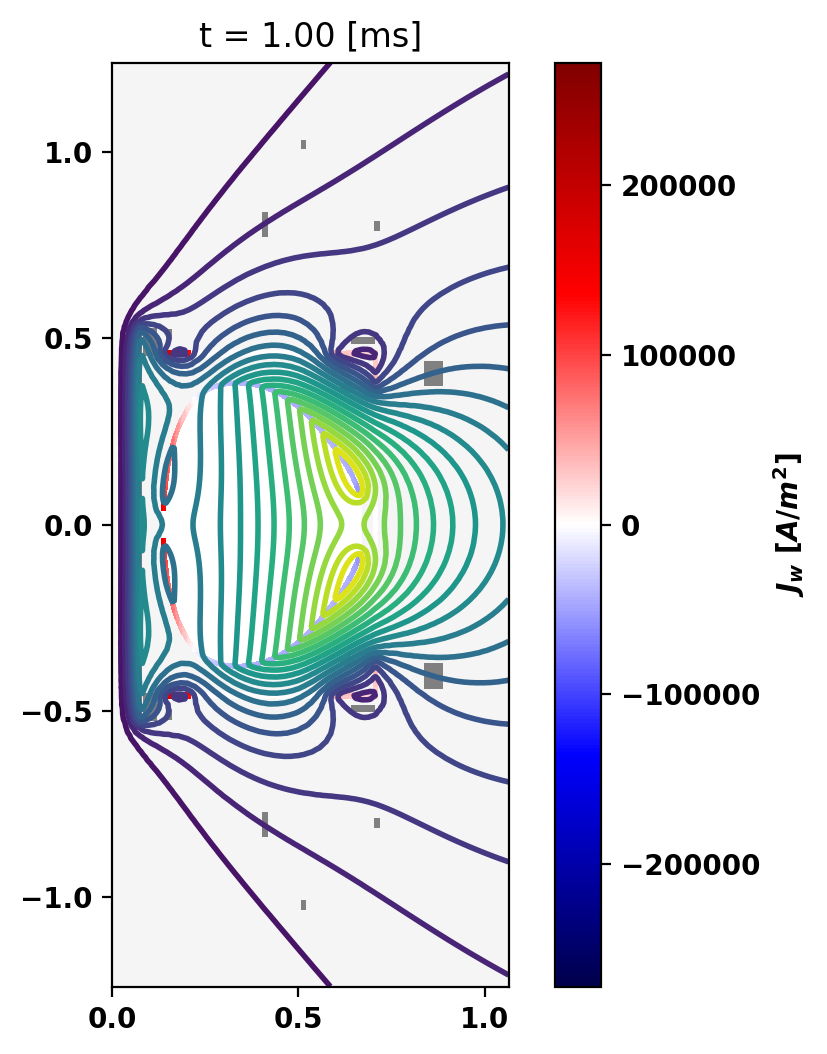

In [11]:
import matplotlib.animation
from IPython.display import HTML
plt.rcParams['savefig.dpi'] = 150

fig, ax = plt.subplots(1,1)
cb = None

def animate(i):
    global cb
    ax.clear()
    mygs.plot_machine(fig,ax,limiter_color=None)
    mygs.plot_psi(fig,ax,timeslices[i+1][1],xpoint_color=None,opoint_color=None,normalized=False,plasma_nlevels=20)
    cb = mygs.plot_eddy(fig,ax,(timeslices[i+1][1]-timeslices[i][1])/dt,colormap='seismic',symmap=True,colorbar=cb)
    ax.set_title('t = {0:.2f} [ms]'.format(timeslices[i+1][0]*1.E3))

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(timeslices)-1)

HTML(ani.to_jshtml())

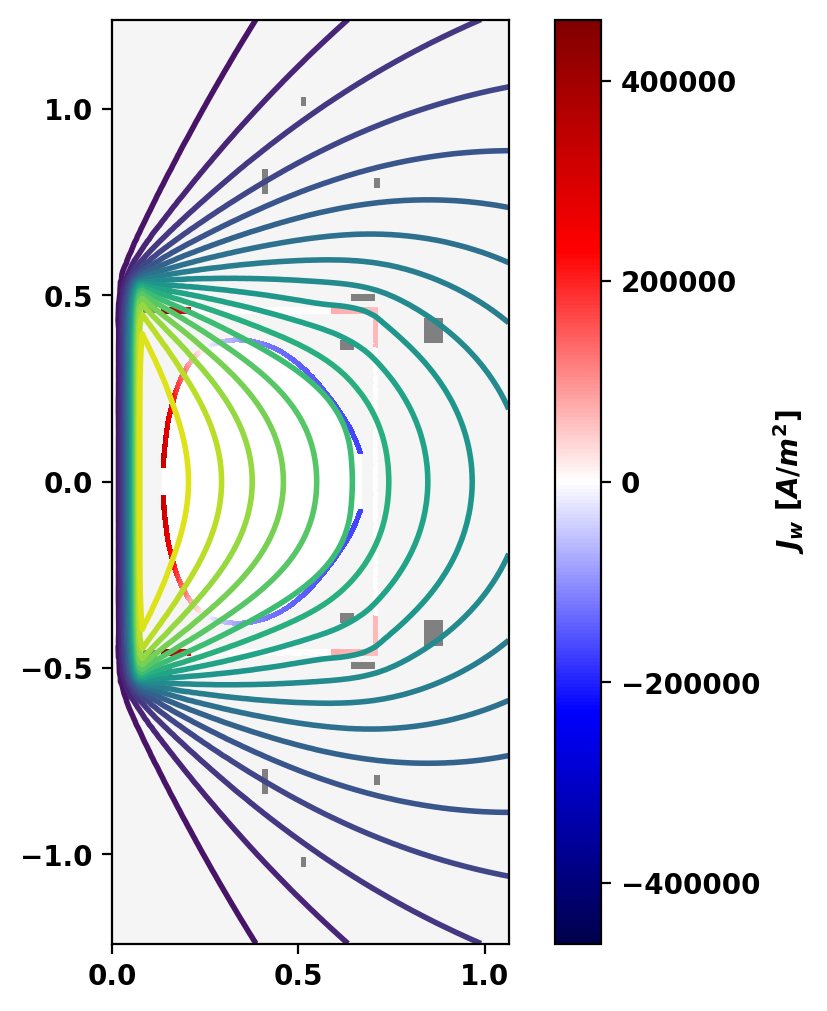

In [12]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,limiter_color=None)
mygs.plot_psi(fig,ax,psi_new,xpoint_color=None,opoint_color=None,normalized=False,plasma_nlevels=20)
mygs.plot_eddy(fig,ax,psi_new/dt,colormap='seismic',symmap=True)

In [13]:
flux_profile = {'type': 'linterp', 'x': np.array([0.0,0.8,1.0]), 'y': np.array([1.0,1.0,0.0])}
mygs.set_profiles(ffp_prof=flux_profile,pp_prof=flux_profile)

In [14]:
mygs.set_psi_dt(psi_last,-dt)
isoflux_pts = create_isoflux(80,0.42,0.0,0.2,1.5,0.2)
mygs.set_isoflux(isoflux_pts)
mygs.init_psi(0.42,0.0,0.15,1.5,0.6)
mygs.solve()
psi_last = mygs.get_psi(False)

Starting non-linear GS solver
     1  1.9984E-01  3.4849E-01  1.2370E-03  4.4415E-01  4.8602E-05 -5.9336E-01
     2  2.0114E-01  3.4723E-01  2.4474E-04  4.4363E-01  4.4229E-05 -1.0580E+00
     3  2.0099E-01  3.4656E-01  5.1972E-05  4.4352E-01  4.2875E-05 -1.1362E+00
     4  2.0087E-01  3.4632E-01  1.3224E-05  4.4349E-01  4.2372E-05 -1.1132E+00
     5  2.0082E-01  3.4624E-01  4.0080E-06  4.4349E-01  4.2150E-05 -1.1036E+00
     6  2.0080E-01  3.4621E-01  1.3086E-06  4.4349E-01  4.2046E-05 -1.1057E+00
     7  2.0080E-01  3.4620E-01  4.3380E-07  4.4349E-01  4.1997E-05 -1.1082E+00
 Timing:   4.3936000001849607E-002
   Source:     1.3328000000910833E-002
   Solve:      1.1896000025444664E-002
   Boundary:   2.2329999919747934E-003
   Other:      1.6478999983519316E-002


Equilibrium Statistics:
  Topology                =   Limited
  Toroidal Current [A]    =    8.0001E+04
  Current Centroid [m]    =    0.386 -0.000
  Magnetic Axis [m]       =    0.443  0.000
  Elongation              =    1.491 (U:  1.491, L:  1.491)
  Triangularity           =    0.224 (U:  0.225, L:  0.222)
  Plasma Volume [m^3]     =    0.679
  q_0, q_95               =    3.213  6.661
  Peak Pressure [Pa]      =    7.5073E+02
  Stored Energy [J]       =    3.4496E+02
  <Beta_pol> [%]          =   30.7677
  <Beta_tor> [%]          =    1.0983
  Diamagnetic flux [Wb]   =    7.5840E-04
  Toroidal flux [Wb]      =    8.4950E-02
  l_i                     =    0.4405

Coil Currents [kA-Turns]:
  REDU:          -11.59 ( -60.00) [ 19.32%]
  REDL:          -11.59 ( -60.00) [ 19.32%]
  ORANGEU:         2.72 ( 200.00) [  1.36%]
  ORANGEL:         2.72 ( 200.00) [  1.36%]
  YELLOWU:        -0.00 (-100.00) [  0.00%]
  YELLOWL:        -0.00 (-100.00) [  0.00%]
  GREENU:         11.58 ( 100.00) 

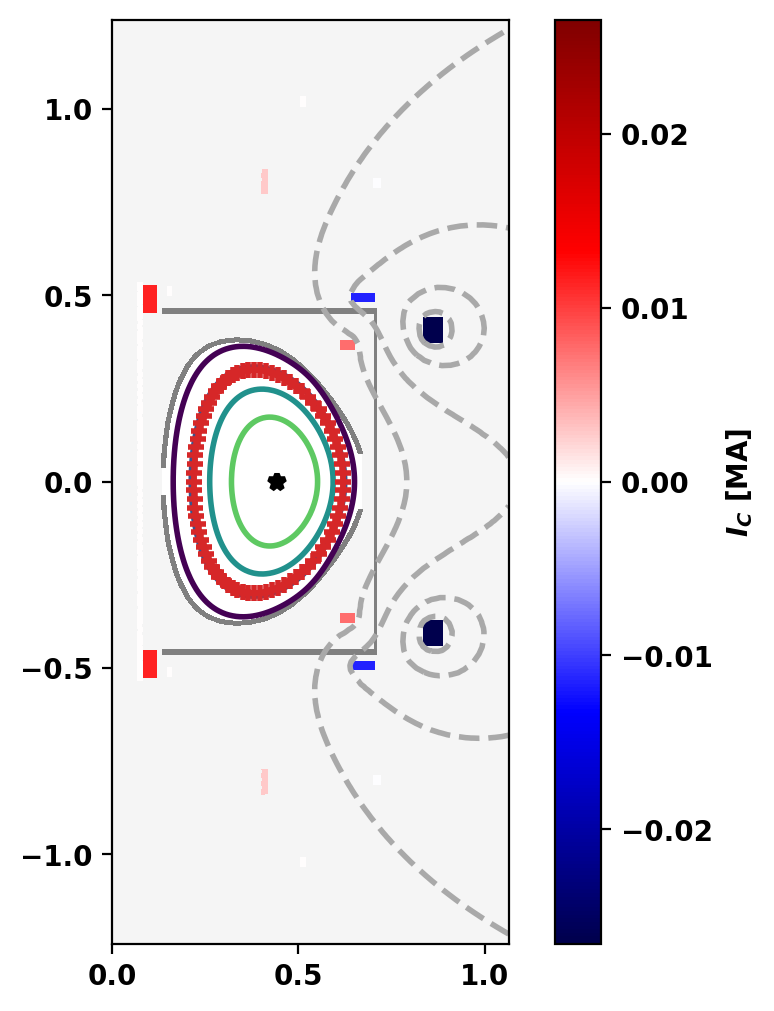

In [15]:
mygs.print_info()
# Plot first case surfaces
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]',coil_symmap=True,limiter_color=None)
mygs.plot_psi(fig,ax,plasma_nlevels=5,vacuum_nlevels=5)
mygs.plot_constraints(fig, ax)
# Print final coil currents
print()
print("Coil Currents [kA-Turns]:")
coil_currents, _ = mygs.get_coil_currents()
for key in coil_dict:
    i = coil_dict[key]['coil_id']
    if coil_currents[i] >= 0.0:
        proximity = coil_currents[i]*100/coil_bounds[i,1]
        near_limit = coil_bounds[i,1]
    else:
        proximity = coil_currents[i]*100/coil_bounds[i,0]
        near_limit = coil_bounds[i,0]
    print('  {0:10} {1:10.2F} ({2:7.2F}) [{3:6.2F}%]'.format(key+":",coil_currents[i]/1.E3,near_limit/1.E3,proximity))

In [16]:
mygs.set_psi_dt(psi_last,1.E-3)
Ip_target = 9.0E4
mygs.set_targets(Ip=Ip_target,Ip_ratio=2.0)
mygs.settings.maxits=200
mygs.update_settings()
mygs.solve()
psi_new = mygs.get_psi(False)

Starting non-linear GS solver
     1  2.2589E-01  3.8948E-01  3.6138E-04  4.4770E-01  8.4084E-05 -1.2487E+00
     2  2.3928E-01  3.9716E-01  3.4478E-04  4.4798E-01  8.5201E-05 -4.7705E-01
     3  2.4145E-01  3.9863E-01  2.2074E-04  4.4721E-01  7.7533E-05 -6.5406E-01
     4  2.3925E-01  3.9731E-01  1.4939E-04  4.4613E-01  6.6848E-05 -1.0537E+00
     5  2.3518E-01  3.9464E-01  1.5528E-04  4.4511E-01  5.7501E-05 -1.0801E+00
     6  2.3087E-01  3.9168E-01  1.6104E-04  4.4434E-01  4.7634E-05 -7.9636E-01
     7  2.2728E-01  3.8913E-01  1.4488E-04  4.4386E-01  4.3152E-05 -9.2633E-01
     8  2.2480E-01  3.8732E-01  1.1435E-04  4.4362E-01  4.0841E-05 -8.0052E-01
     9  2.2342E-01  3.8628E-01  8.1268E-05  4.4356E-01  4.1349E-05 -5.0637E-01
    10  2.2286E-01  3.8585E-01  5.3700E-05  4.4360E-01  4.2521E-05 -6.7038E-01
    11  2.2283E-01  3.8580E-01  3.4860E-05  4.4367E-01  4.3466E-05 -9.2118E-01
    12  2.2305E-01  3.8595E-01  2.3680E-05  4.4373E-01  4.3993E-05 -1.1378E+00
    13  2.2332E-01  3.

Equilibrium Statistics:
  Topology                =   Limited
  Toroidal Current [A]    =    9.0001E+04
  Current Centroid [m]    =    0.386  0.000
  Magnetic Axis [m]       =    0.444  0.000
  Elongation              =    1.493 (U:  1.493, L:  1.493)
  Triangularity           =    0.228 (U:  0.227, L:  0.228)
  Plasma Volume [m^3]     =    0.685
  q_0, q_95               =    2.895  6.028
  Peak Pressure [Pa]      =    9.4139E+02
  Stored Energy [J]       =    4.3607E+02
  <Beta_pol> [%]          =   30.8471
  <Beta_tor> [%]          =    1.3743
  Diamagnetic flux [Wb]   =    9.5547E-04
  Toroidal flux [Wb]      =    8.6131E-02
  l_i                     =    0.4392

Coil Currents [kA-Turns]:
  REDU:          -13.08 ( -60.00) [ 21.79%]
  REDL:          -13.08 ( -60.00) [ 21.79%]
  ORANGEU:         2.76 ( 200.00) [  1.38%]
  ORANGEL:         2.76 ( 200.00) [  1.38%]
  YELLOWU:        -0.00 (-100.00) [  0.00%]
  YELLOWL:        -0.00 (-100.00) [  0.00%]
  GREENU:         11.85 ( 100.00) 

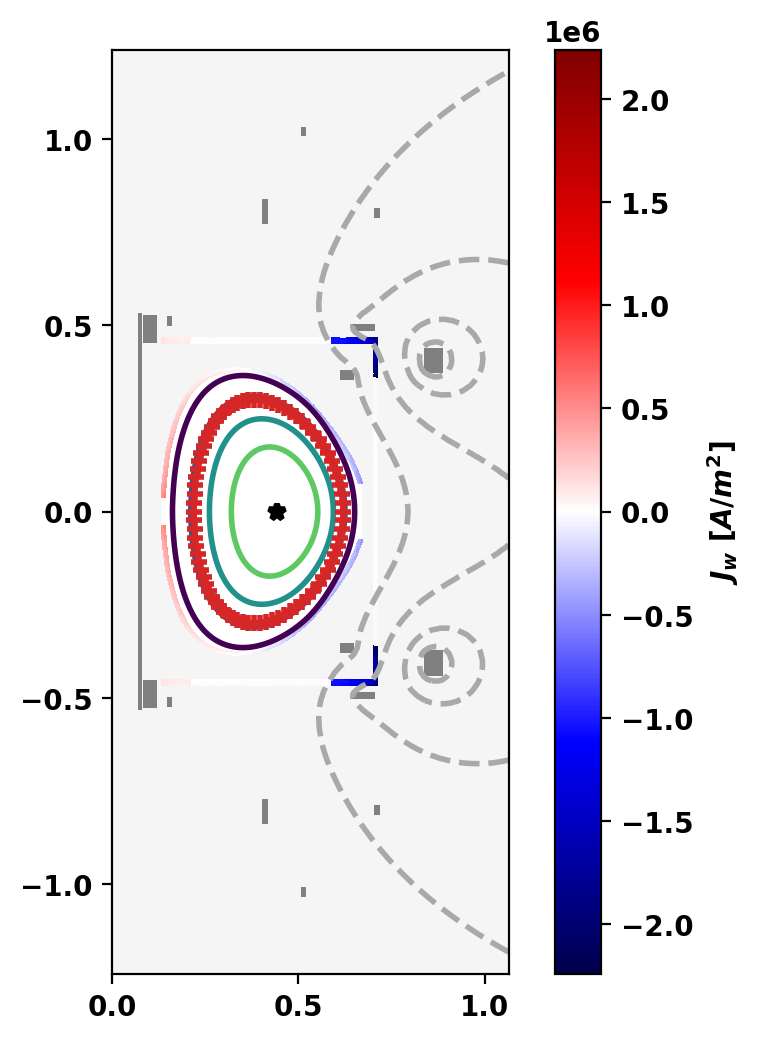

In [17]:
mygs.print_info()
# Plot first case surfaces
fig, ax = plt.subplots(1,1)
# mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]',coil_symmap=True,limiter_color=None)
mygs.plot_machine(fig,ax,limiter_color=None)
mygs.plot_psi(fig,ax,plasma_nlevels=5,vacuum_nlevels=5)
mygs.plot_eddy(fig,ax,(psi_new-psi_last)/dt,colormap='seismic',symmap=True)
mygs.plot_constraints(fig, ax)
# Print final coil currents
print()
print("Coil Currents [kA-Turns]:")
coil_currents, _ = mygs.get_coil_currents()
for key in coil_dict:
    i = coil_dict[key]['coil_id']
    if coil_currents[i] >= 0.0:
        proximity = coil_currents[i]*100/coil_bounds[i,1]
        near_limit = coil_bounds[i,1]
    else:
        proximity = coil_currents[i]*100/coil_bounds[i,0]
        near_limit = coil_bounds[i,0]
    print('  {0:10} {1:10.2F} ({2:7.2F}) [{3:6.2F}%]'.format(key+":",coil_currents[i]/1.E3,near_limit/1.E3,proximity))

In [18]:
mygs.set_psi_dt(psi_last,-dt)
isoflux_pts = create_isoflux(80,0.39,0.0,0.14,1.5,-0.4)
mygs.set_isoflux(isoflux_pts)
mygs.init_psi(0.42,0.0,0.15,1.5,0.6)
mygs.solve()

Starting non-linear GS solver
     1  3.2105E-01  5.6388E-01  1.2694E-03  4.1286E-01 -1.5594E-05  2.9622E+00
     2  3.4570E-01  5.9038E-01  5.1651E-04  4.1236E-01 -3.3182E-06  2.3013E+00
     3  3.5137E-01  5.9710E-01  2.4944E-04  4.1224E-01  4.4509E-07  1.1651E+00
     4  3.5322E-01  5.9942E-01  1.0688E-04  4.1220E-01 -1.4778E-07  2.7428E+00
     5  3.5390E-01  6.0030E-01  4.1941E-05  4.1219E-01 -1.5183E-06  3.2903E+00
     6  3.5415E-01  6.0063E-01  1.5651E-05  4.1218E-01 -2.7080E-06  3.4574E+00
     7  3.5426E-01  6.0077E-01  5.6835E-06  4.1218E-01 -3.5180E-06  3.5005E+00
     8  3.5430E-01  6.0082E-01  2.0337E-06  4.1218E-01 -4.0400E-06  3.5137E+00
     9  3.5431E-01  6.0084E-01  7.2376E-07  4.1218E-01 -4.3695E-06  3.5186E+00
 Timing:  0.32814300000609364     
   Source:     6.8034000054467469E-002
   Solve:      6.5044000046327710E-002
   Boundary:   1.0412000032374635E-002
   Other:     0.18465299987292383     


0

Equilibrium Statistics:
  Topology                =   Limited
  Toroidal Current [A]    =    8.9998E+04
  Current Centroid [m]    =    0.387 -0.000
  Magnetic Axis [m]       =    0.412 -0.000
  Elongation              =    1.507 (U:  1.507, L:  1.507)
  Triangularity           =   -0.544 (U: -0.542, L: -0.545)
  Plasma Volume [m^3]     =    0.443
  q_0, q_95               =    2.221  3.237
  Peak Pressure [Pa]      =    1.4302E+03
  Stored Energy [J]       =    4.2355E+02
  <Beta_pol> [%]          =   31.2200
  <Beta_tor> [%]          =    2.0784
  Diamagnetic flux [Wb]   =    9.8314E-04
  Toroidal flux [Wb]      =    5.3468E-02
  l_i                     =    0.4762

Coil Currents [kA-Turns]:
  REDU:            2.73 (  60.00) [  4.54%]
  REDL:            2.73 (  60.00) [  4.54%]
  ORANGEU:       -89.89 (-200.00) [ 44.95%]
  ORANGEL:       -89.89 (-200.00) [ 44.94%]
  YELLOWU:        -0.00 (-100.00) [  0.00%]
  YELLOWL:        -0.00 (-100.00) [  0.00%]
  GREENU:        -75.27 (-100.00) 

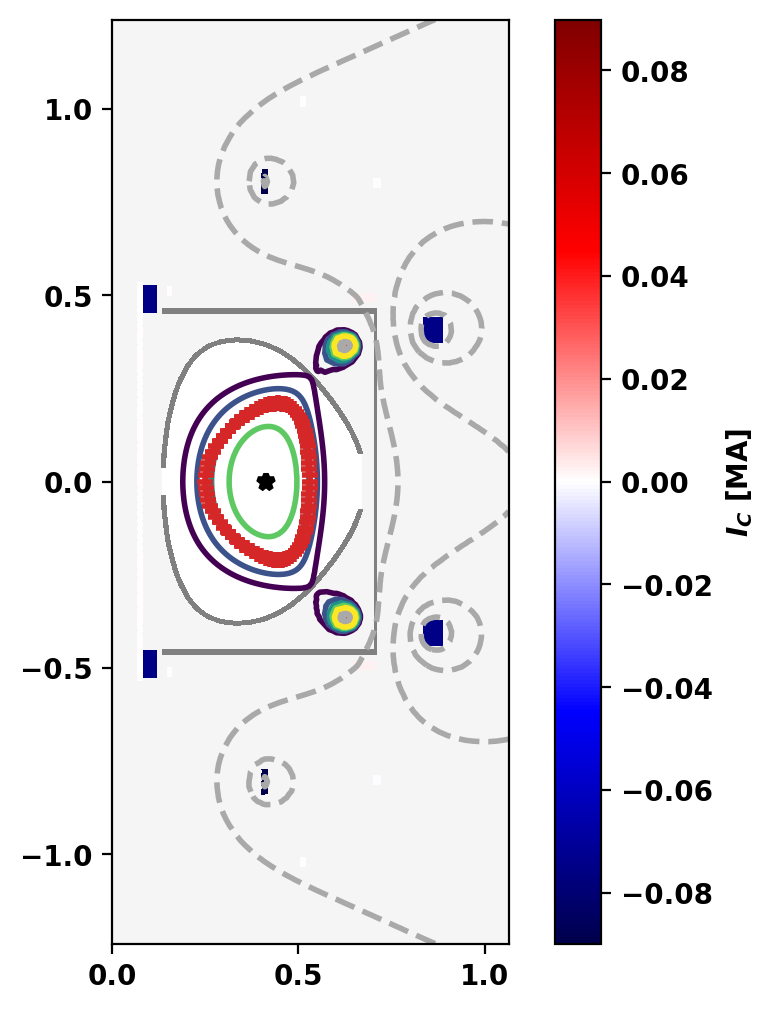

In [19]:
mygs.print_info()
# Plot first case surfaces
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]',coil_symmap=True,limiter_color=None)
mygs.plot_psi(fig,ax,plasma_nlevels=5,vacuum_nlevels=5)
mygs.plot_constraints(fig, ax)
# Print final coil currents
print()
print("Coil Currents [kA-Turns]:")
coil_currents, _ = mygs.get_coil_currents()
for key in coil_dict:
    i = coil_dict[key]['coil_id']
    if coil_currents[i] >= 0.0:
        proximity = coil_currents[i]*100/coil_bounds[i,1]
        near_limit = coil_bounds[i,1]
    else:
        proximity = coil_currents[i]*100/coil_bounds[i,0]
        near_limit = coil_bounds[i,0]
    print('  {0:10} {1:10.2F} ({2:7.2F}) [{3:6.2F}%]'.format(key+":",coil_currents[i]/1.E3,near_limit/1.E3,proximity))

In [20]:
isoflux_pts = create_isoflux(80,0.42,0.0,0.18,1.5,0.5)
mygs.set_isoflux(isoflux_pts)
mygs.solve()

Starting non-linear GS solver
     1  3.5432E-01  6.0085E-01  3.0324E-02  4.2307E-01  4.7336E-05  2.4622E+00
     2  3.0964E-01  5.4696E-01  6.2969E-03  4.2781E-01 -2.2094E-05 -1.1563E+00
     3  3.0307E-01  5.3603E-01  3.1188E-03  4.2923E-01 -4.0026E-05 -1.7266E+00
     4  2.8692E-01  5.1421E-01  1.5115E-03  4.2976E-01 -4.7686E-05  5.4899E-01
     5  2.7541E-01  4.9876E-01  7.6936E-04  4.3001E-01 -4.8324E-05 -5.4899E+00
     6  2.6876E-01  4.8983E-01  3.9546E-04  4.3014E-01 -5.1180E-05 -2.8091E-01
     7  2.6520E-01  4.8506E-01  2.0469E-04  4.3021E-01 -5.4506E-05  2.5646E+00
     8  2.6334E-01  4.8256E-01  1.0567E-04  4.3024E-01 -5.6191E-05  3.2689E+00
     9  2.6240E-01  4.8128E-01  5.4405E-05  4.3026E-01 -5.6913E-05  3.2188E+00
    10  2.6191E-01  4.8063E-01  2.7713E-05  4.3027E-01 -5.7211E-05  3.1527E+00
    11  2.6167E-01  4.8031E-01  1.4108E-05  4.3027E-01 -5.7336E-05  3.0262E+00
    12  2.6154E-01  4.8014E-01  7.1560E-06  4.3028E-01 -5.7400E-05  2.9348E+00
    13  2.6148E-01  4.

0

Equilibrium Statistics:
  Topology                =   Limited
  Toroidal Current [A]    =    9.0002E+04
  Current Centroid [m]    =    0.374  0.000
  Magnetic Axis [m]       =    0.430 -0.000
  Elongation              =    1.611 (U:  1.611, L:  1.611)
  Triangularity           =    0.466 (U:  0.466, L:  0.467)
  Plasma Volume [m^3]     =    0.559
  q_0, q_95               =    2.464  5.836
  Peak Pressure [Pa]      =    1.1183E+03
  Stored Energy [J]       =    4.0761E+02
  <Beta_pol> [%]          =   32.5083
  <Beta_tor> [%]          =    1.4794
  Diamagnetic flux [Wb]   =    8.9450E-04
  Toroidal flux [Wb]      =    7.4644E-02
  l_i                     =    0.4260

Coil Currents [kA-Turns]:
  REDU:           -9.32 ( -60.00) [ 15.54%]
  REDL:           -9.32 ( -60.00) [ 15.54%]
  ORANGEU:        30.54 ( 200.00) [ 15.27%]
  ORANGEL:        30.54 ( 200.00) [ 15.27%]
  YELLOWU:         0.00 ( 100.00) [  0.00%]
  YELLOWL:         0.00 ( 100.00) [  0.00%]
  GREENU:         71.39 ( 100.00) 

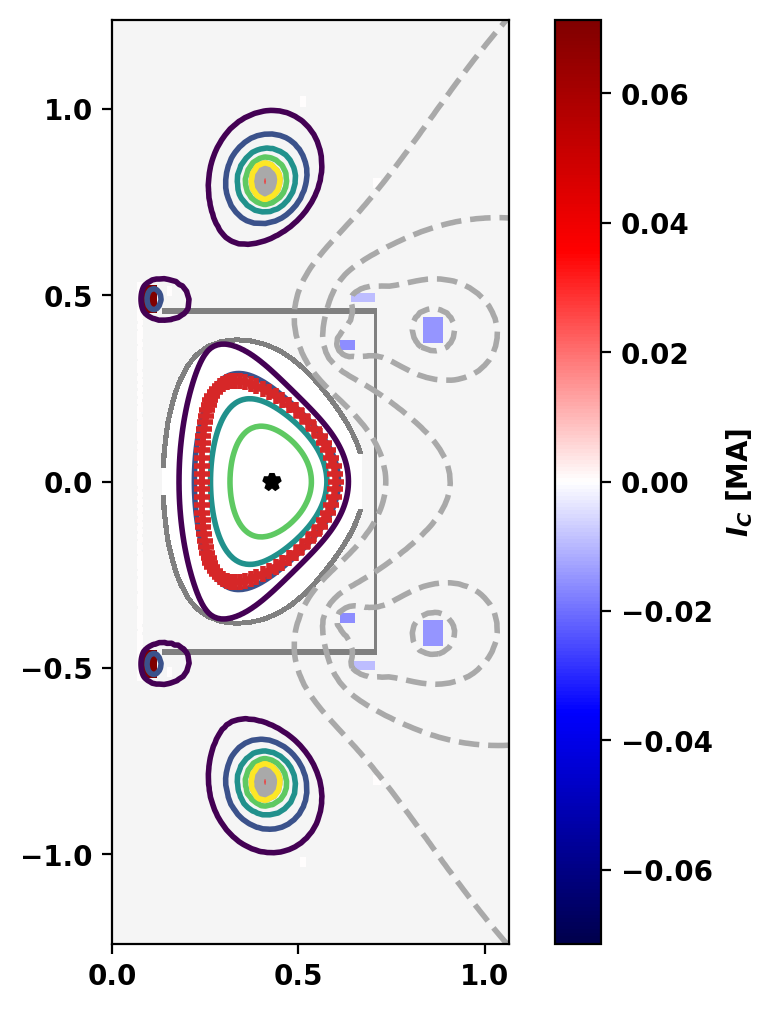

In [21]:
mygs.print_info()
# Plot first case surfaces
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]',coil_symmap=True,limiter_color=None)
mygs.plot_psi(fig,ax,plasma_nlevels=5,vacuum_nlevels=5)
mygs.plot_constraints(fig, ax)
# Print final coil currents
print()
print("Coil Currents [kA-Turns]:")
coil_currents, _ = mygs.get_coil_currents()
for key in coil_dict:
    i = coil_dict[key]['coil_id']
    if coil_currents[i] >= 0.0:
        proximity = coil_currents[i]*100/coil_bounds[i,1]
        near_limit = coil_bounds[i,1]
    else:
        proximity = coil_currents[i]*100/coil_bounds[i,0]
        near_limit = coil_bounds[i,0]
    print('  {0:10} {1:10.2F} ({2:7.2F}) [{3:6.2F}%]'.format(key+":",coil_currents[i]/1.E3,near_limit/1.E3,proximity))

Longest L/R time = 5.1203E-03 [s]


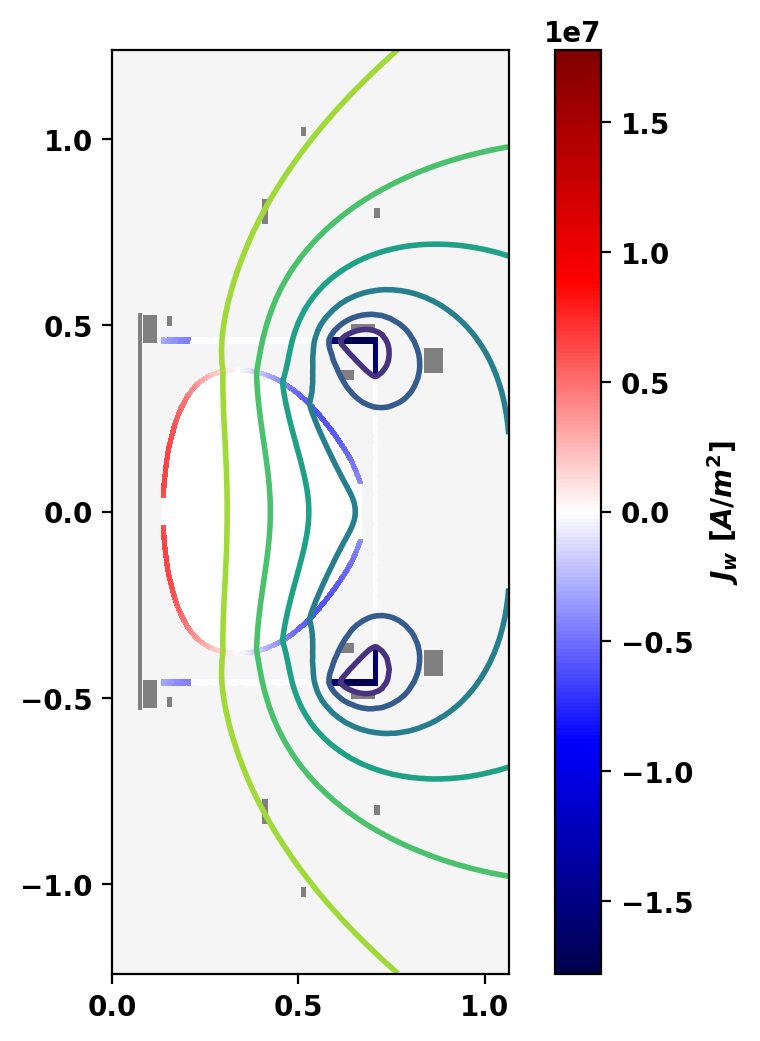

In [22]:
psi0 = mygs.get_psi(False)
eig_vals, eig_vecs = mygs.eig_wall(10)
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,limiter_color=None)
mygs.plot_psi(fig,ax,eig_vecs[0,:],xpoint_color=None,opoint_color=None,normalized=False) # ,plasma_nlevels=20
mygs.plot_eddy(fig,ax,eig_vecs[0,:]*abs(eig_vals[0,0]),colormap='seismic',symmap=True)
print('Longest L/R time = {0:.4E} [s]'.format(1.0/eig_vals[0,0]))

[-434.85656368   95.81770961  229.88692604]
Growth time = -2.2996E-03 [s]


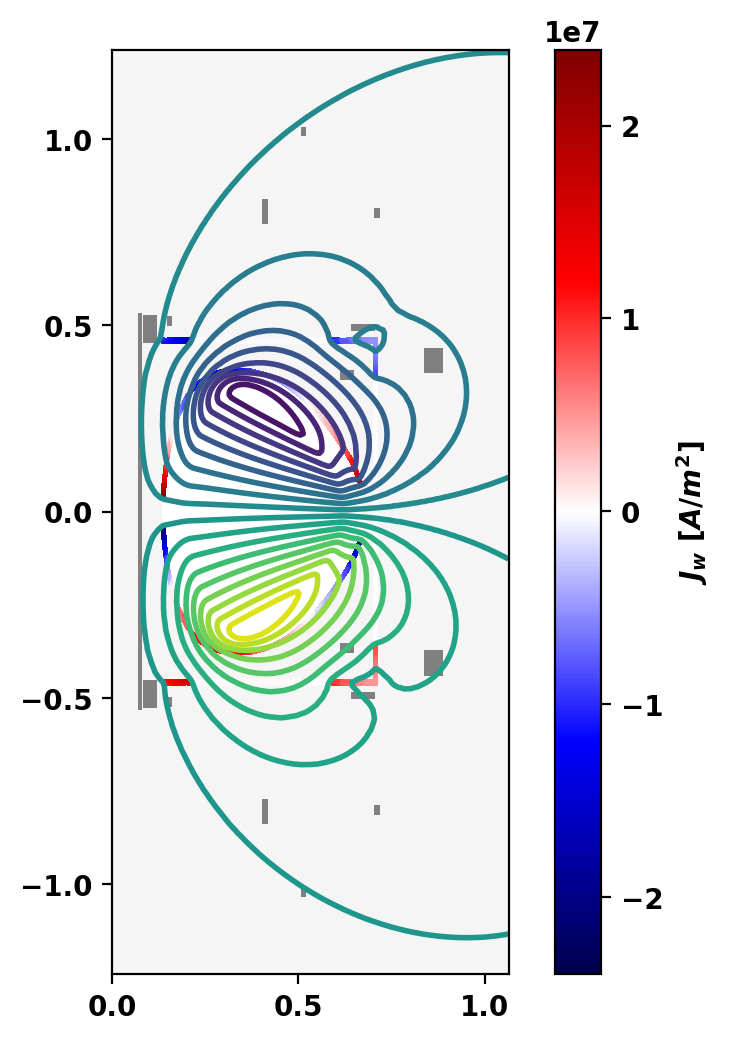

In [23]:
psi0 = mygs.get_psi(False)
eig_vals, eig_vecs = mygs.eig_td(-2.E4,10,False)
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,limiter_color=None)
mygs.plot_psi(fig,ax,eig_vecs[0,:],xpoint_color=None,opoint_color=None,normalized=False,plasma_nlevels=20)
mygs.plot_eddy(fig,ax,eig_vecs[0,:]*abs(eig_vals[0,0]),colormap='seismic')
print(eig_vals[:3,0])
print('Growth time = {0:.4E} [s]'.format(1.0/eig_vals[0,0]))

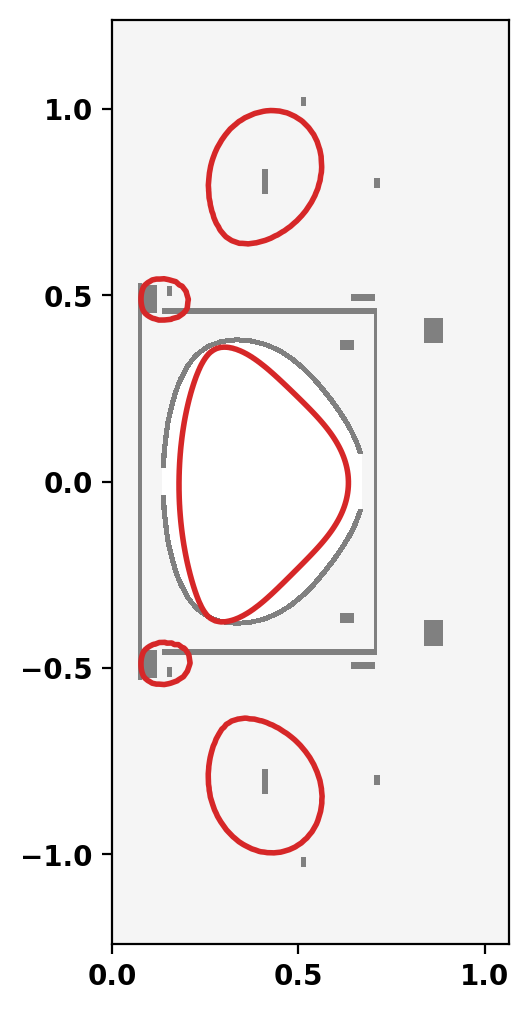

In [24]:
max_loc = abs(eig_vecs[0,:]).argmax()
psi_ic = psi0-0.025*eig_vecs[0,:]*(mygs.psi_bounds[1]-mygs.psi_bounds[0])/eig_vecs[0,max_loc]*np.sign(mygs.r[max_loc,1])
#
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,limiter_color=None)
mygs.plot_psi(fig,ax,psi_ic,normalized=False,plasma_levels=[mygs.psi_bounds[0],],plasma_color='tab:red',xpoint_color=None,opoint_color=None)
mygs.set_psi(psi_ic)
# _ = ax.set_ylim(-0.6,0.6)

In [25]:
mygs.settings.pm=False
mygs.update_settings()
mygs.set_isoflux(None)
mygs.setup_td(1.E-5,1.E-13,1.E-11)

In [26]:
sim_time = 0.0
dt = 2.E-4
nplot = 1
nstatus = 1
results = [mygs.get_psi()]
results_raw = [mygs.get_psi(False)]
z0 = [[sim_time,mygs.o_point[1]],]
eig_comp = [[sim_time,np.dot(eig_vecs[0,:],mygs.get_psi(normalized=False)-psi0)],]
t00 = time.perf_counter()
for i in range(140):
    t0 = time.perf_counter()
    sim_time, _, nl_its, lin_its, nretry = mygs.step_td(sim_time,dt)
    t1 = time.perf_counter()
    if i % nstatus == 0:
        print('{0:.5E} {1:.5E} {2:4d} {3:4d} {5:8.3f} {4:4d} {6:.5E}'.format(sim_time,dt,nl_its,lin_its,nretry,t1-t0,coil_currents[-1]))
    z0.append([sim_time,mygs.o_point[1]])
    eig_comp.append([sim_time,np.dot(eig_vecs[0,:],mygs.get_psi(normalized=False)-psi0)])
    if i % nplot == 0:
        results.append(mygs.get_psi())
        results_raw.append(mygs.get_psi(False))
t1 = time.perf_counter()
print('Total time = {0:8.3f}'.format(t1-t00))

2.00000E-04 2.00000E-04    2   14    0.125    0 6.28739E+00
4.00000E-04 2.00000E-04    2   12    0.057    0 6.28739E+00
6.00000E-04 2.00000E-04    2   12    0.057    0 6.28739E+00
8.00000E-04 2.00000E-04    2   12    0.059    0 6.28739E+00
1.00000E-03 2.00000E-04    2   12    0.057    0 6.28739E+00
1.20000E-03 2.00000E-04    2   12    0.058    0 6.28739E+00
1.40000E-03 2.00000E-04    2   12    0.057    0 6.28739E+00
1.60000E-03 2.00000E-04    2   12    0.057    0 6.28739E+00
1.80000E-03 2.00000E-04    2   12    0.056    0 6.28739E+00
2.00000E-03 2.00000E-04    2   12    0.057    0 6.28739E+00
2.20000E-03 2.00000E-04    2   12    0.056    0 6.28739E+00
2.40000E-03 2.00000E-04    2   12    0.058    0 6.28739E+00
2.60000E-03 2.00000E-04    2   12    0.058    0 6.28739E+00
2.80000E-03 2.00000E-04    2   12    0.056    0 6.28739E+00
3.00000E-03 2.00000E-04    2   13    0.063    0 6.28739E+00
3.20000E-03 2.00000E-04    2   13    0.062    0 6.28739E+00
3.40000E-03 2.00000E-04    2   13    0.0

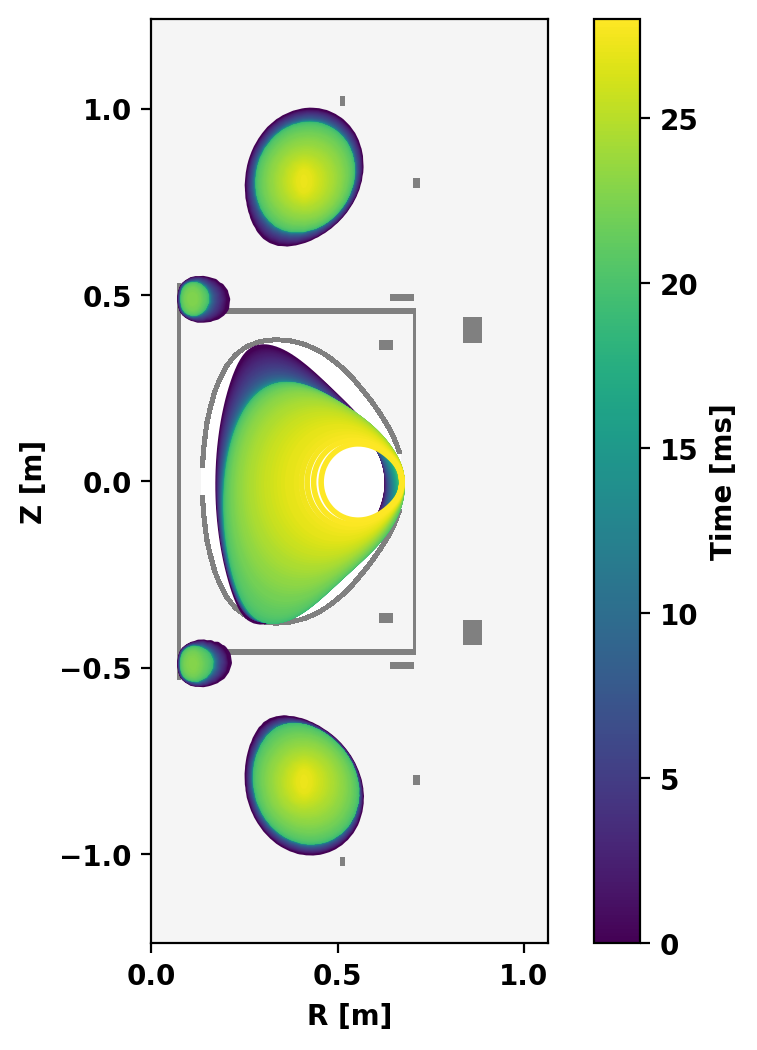

In [27]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,limiter_color=None)
colors = plt.cm.viridis(np.linspace(0, 1, len(results)))
for i, result in enumerate(results):
    mygs.plot_psi(fig,ax,psi=result,plasma_levels=[1.0],plasma_color=[colors[i]],vacuum_nlevels=0,xpoint_color=None,opoint_color=None)
norm = mpl.colors.Normalize(vmin=0.0, vmax=sim_time*1.E3)
# ax.set_ylim(-0.6,0.6)
ax.set_xlabel('R [m]')
ax.set_ylabel('Z [m]')
_ = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=plt.cm.viridis),ax=ax,label='Time [ms]')

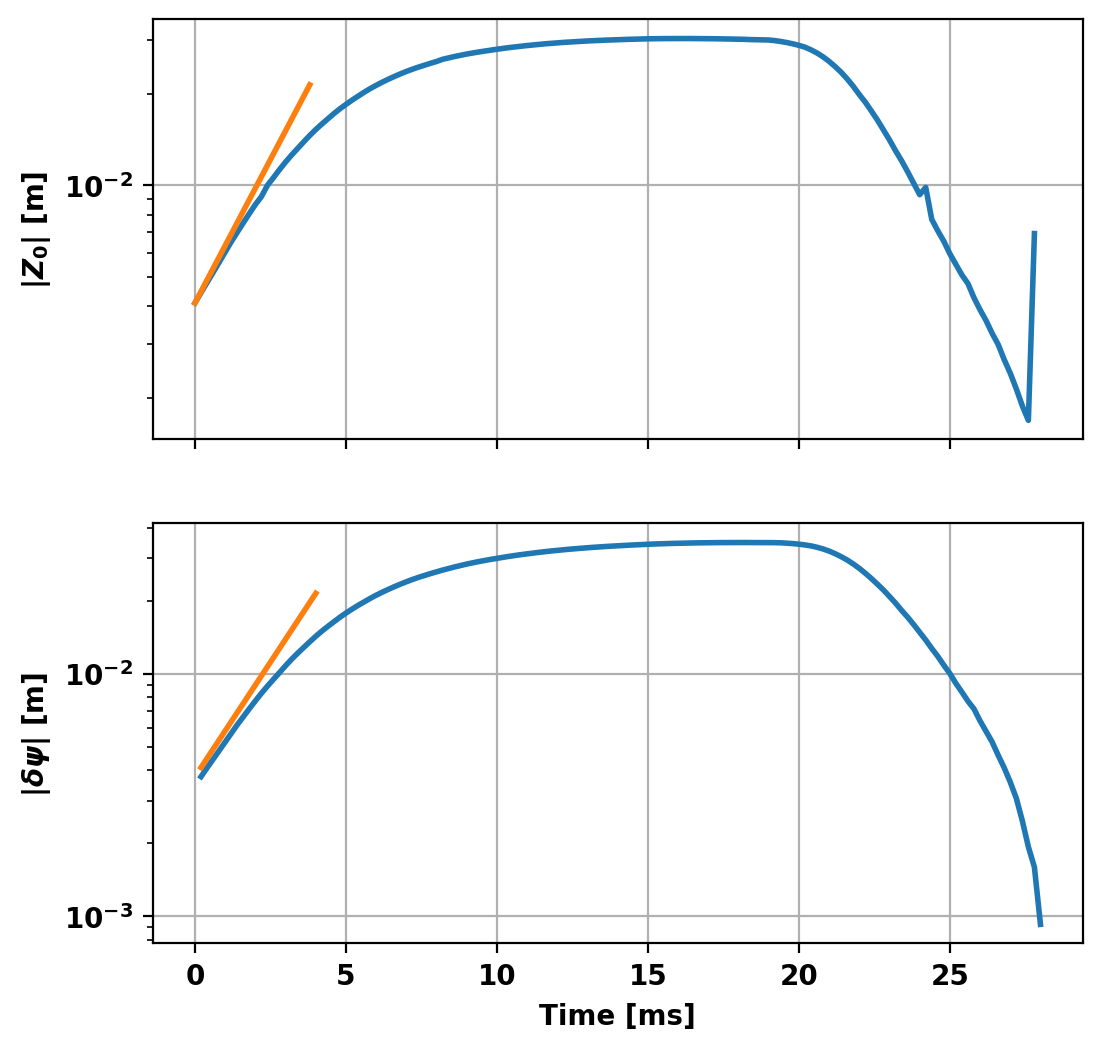

In [28]:
fig, ax = plt.subplots(2,1,sharex=True)
z_hist = np.asarray(z0); z_hist = z_hist[1:,:] - [z_hist[1,0], z_hist[0,1]]
ax[0].semilogy(z_hist[:,0]*1.E3,abs(z_hist[:,1]))
ax[0].semilogy(z_hist[:20,0]*1.E3,abs(z_hist[0,1])*np.exp(-z_hist[:20,0]*eig_vals[0,0]))
ax[0].set_ylabel(r'$|Z_0|$ [m]')
ax[0].grid(True)
eig_hist = np.asarray(eig_comp); eig_hist = eig_hist[1:,:]
ax[1].semilogy(eig_hist[:,0]*1.E3,abs(eig_hist[:,1]))
ax[1].semilogy(eig_hist[:20,0]*1.E3,abs(eig_hist[0,1])*np.exp(-eig_hist[:20,0]*eig_vals[0,0]))
ax[1].set_ylabel(r'$|\delta \psi|$ [m]')
ax[1].grid(True)
_ = ax[-1].set_xlabel(r'Time [ms]')

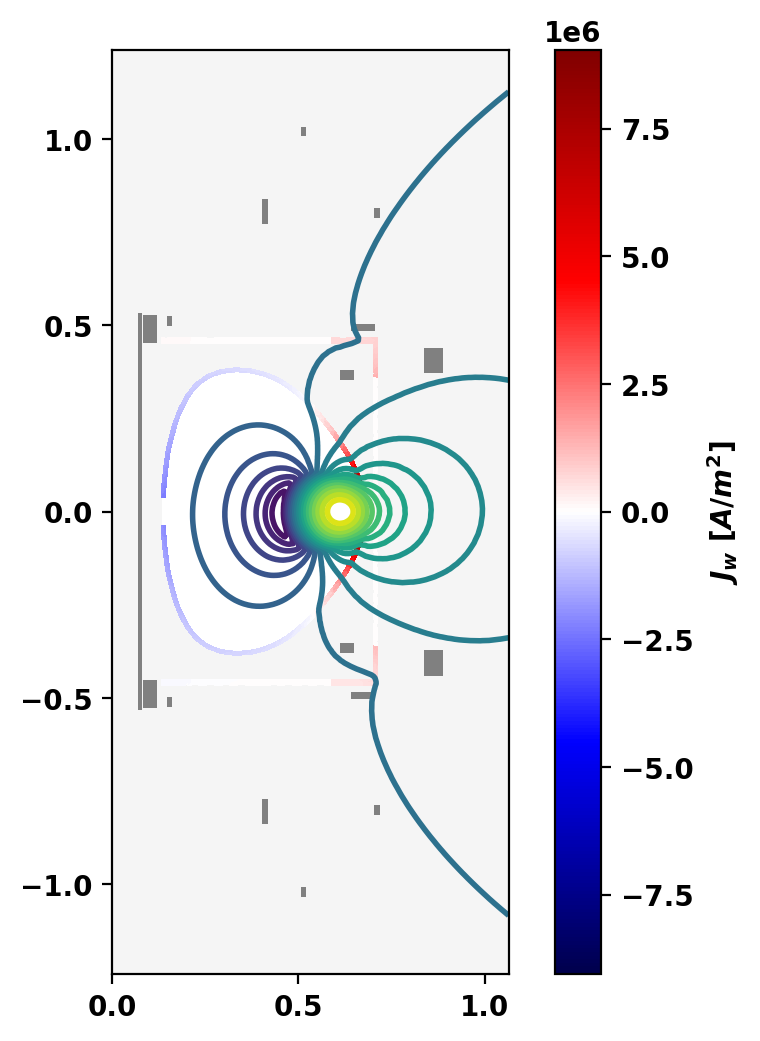

In [29]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,limiter_color=None)
mygs.plot_psi(fig,ax,psi=results_raw[-1]-results_raw[-2],normalized=False,xpoint_color=None,opoint_color=None,plasma_nlevels=20)
mygs.plot_eddy(fig,ax,(results_raw[-1]-results_raw[-2])/dt,colormap='seismic',symmap=True)